In [1]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter, defaultdict
from IPython.display import clear_output
%matplotlib inline

In [2]:
with open("adult.test.txt_bug") as handler1, open("adult.test.txt", 'w') as handler2:
    for line in handler1:
        print(line.strip()[:-1], file=handler2)

In [3]:
def read_file(filename):
    with open(filename) as handler:
        return [line.strip().split(", ") for line in handler]

In [4]:
train = read_file("adult.data.txt")
test = read_file("adult.test.txt")

In [5]:
assert len(set(len(line) for line in train)) == 1

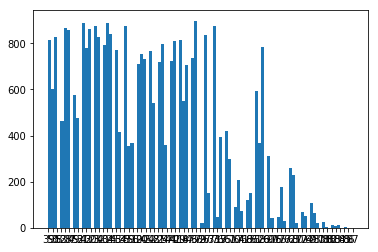

In [6]:
plt.hist(list(line[0] for line in train), bins=100)
plt.show()

In [7]:
keys_num = len(train[0])

In [8]:
for line in train:
    assert len(line) == keys_num

In [9]:
description = """age – The age of the individual
type_employer – The type of employer the individual has. Whether they are government, military, private, an d so on.
fnlwgt – The \# of people the census takers believe that observation represents. We will be ignoring this variable
education – The highest level of education achieved for that individual
education_num – Highest level of education in numerical form
marital – Marital status of the individual
occupation – The occupation of the individual
relationship – A bit more difficult to explain. Contains family relationship values like husband, father, and so on, but only contains one per observation. I’m not sure what this is supposed to represent
race – descriptions of the individuals race. Black, White, Eskimo, and so on
sex – Biological Sex
capital_gain – Capital gains recorded
capital_loss – Capital Losses recorded
hr_per_week – Hours worked per week
country – Country of origin for person
income – Boolean Variable. Whether or not the person makes more than \$50,000 per annum income."""
description = description.split('\n')

In [10]:
for key in range(keys_num):
    print('-' * 100)
    print("{})".format(key), len(set(line[key] for line in train)), description[key])

----------------------------------------------------------------------------------------------------
0) 73 age – The age of the individual
----------------------------------------------------------------------------------------------------
1) 9 type_employer – The type of employer the individual has. Whether they are government, military, private, an d so on.
----------------------------------------------------------------------------------------------------
2) 21648 fnlwgt – The \# of people the census takers believe that observation represents. We will be ignoring this variable
----------------------------------------------------------------------------------------------------
3) 16 education – The highest level of education achieved for that individual
----------------------------------------------------------------------------------------------------
4) 16 education_num – Highest level of education in numerical form
------------------------------------------------------------------

In [11]:
def split_one_hot(values, splits):
    result = np.zeros((len(values), len(splits) - 1))
    for i, value in enumerate(values):
        for index, (min_bound, max_bound) in enumerate(zip(splits[:-1], splits[1:])):
            if (value >= min_bound) and (value < max_bound):
                result[i][index] = 1
                break
    return result

def split_one_hot_uniform(values, batches):
    minimum = np.min(values)
    maximum = np.max(values)
    splits = np.linspace(minimum, maximum, num=batches + 1)
    return split_one_hot(values, splits)

def equal_one_hot(values, positive_value):
    result = np.array([1, 0]).reshape([1, -1]).repeat(len(values), axis=0)
    positive_indices = (np.array(values) == positive_value)
    result[positive_indices, 0] = 0
    result[positive_indices, 1] = 1
    return result

def around_one_hot(values, middle_value):
    result = np.zeros((len(values), 3))
    middle_indices = (np.array(values) == middle_value)
    more_indices = (np.array(values) > middle_value)
    less_indices = (np.array(values) < middle_value)
    result[middle_indices, 1] = 1
    result[more_indices, 2] = 1
    result[less_indices, 0] = 1
    return result

def make_map(values):
    values_set = set(values)
    return {
        value: i
        for i, value in enumerate(values_set)
    }

def map_one_hot(values, map_to_label):
    max_label = len(map_to_label)
    result = np.zeros((len(values), max_label))
    for i, value in enumerate(values):
        result[i][map_to_label[value]] = 1
    return result

def map_one_hot_le(values, map_to_label):
    max_label = len(map_to_label)
    result = np.zeros((len(values), max_label))
    for i, value in enumerate(values):
        for j in range(i + 1):
            result[j][map_to_label[value]] = 1
    return result

def function_one_hot(values, function):
    labels = list(map(function, values))
    max_label = len(map_to_label)
    result = np.zeros((len(values), max_label))
    for i, label in enumerate(labels):
        result[i][label] = 1
    return result

In [12]:
def make_dataset(raw_data, average_positive_by_contry):
    columns = [
        [line[i] for line in raw_data]
        for i in range(len(raw_data[0]))
    ]

    # map one_hot
    one_hot_indices = [1, 5, 6, 7, 8, 9]
    maps = [
        make_map(columns[index])
        for index in one_hot_indices
    ]
    features = []
    for index, map_to_labels in zip(one_hot_indices, maps):
        features.append(map_one_hot(columns[index], map_to_labels))
    
    # le one_hot
    education_num_map = make_map(columns[4])
    features.append(map_one_hot(columns[4], education_num_map))
    
    # intervel one_hot
    batches_indices = [0]
    batches = [5]
    for index, batch in zip(batches_indices, batches):
        values = list(map(int, columns[index]))
        features.append(split_one_hot_uniform(values, batches=batch))

    # zero or not
    for index in [10, 11]:
        values = list(map(int, columns[index]))
        features.append(equal_one_hot(values, 0))
    function_indices = []
    
    # more, less or equal
    values = list(map(int, columns[12]))
    features.append(around_one_hot(values, 40))
    
    # contry

    def featrue_by_contry(country):
        if country == 'United-States':
            return [0, 1, 0]
        elif average_positive_by_contry[country] < average_positive_by_contry['United-States']:
            return [1, 0, 0]
        else:
            return [0, 0, 1]

    contry_features = np.array([
        featrue_by_contry(country)
        for country in columns[13]
    ])
    features.append(contry_features)
    
    targets = np.array([
        0 if target == '<=50K' else 1
        for target in columns[-1]
    ])
    
    return np.concatenate(features, axis=1), targets

In [13]:
countries = set(line[13] for line in train)
average_positive_target_rate = {}
countries_positives = defaultdict(lambda: 0)
countries_negatives = defaultdict(lambda: 0)
for line in train:
    if line[-1] == '<=50K':
        countries_negatives[line[13]] += 1
    else:
        countries_positives[line[13]] += 1
for country in countries:
    support = countries_positives[country] + countries_negatives[country]
    rate = float(countries_positives[country]) / support
    average_positive_target_rate[country] = rate

In [14]:
for line in test:
    assert len(line) == keys_num

In [15]:
X_train, Y_train = make_dataset(train, average_positive_target_rate)
X_test, Y_test = make_dataset(test, average_positive_target_rate)

In [16]:
X_train.shape, X_test.shape

((32561, 75), (16281, 75))

In [17]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

In [18]:
def get_catboost_acc(train_x, train_y, test_x, test_y):
    catboost_model = CatBoostClassifier(iterations=15)
    catboost_model.fit(train_x, train_y, verbose=0)
    catboost_predictions = catboost_model.predict(test_x)
    return accuracy_score(catboost_predictions, test_y)

In [19]:
def k_fold(X, Y, accuracy_calculator, folds=5):
    assert len(X) == len(Y)
    kf = KFold(n_splits=folds)
    evals = []
    for train_index, test_index in kf.split(X):
        train_x, test_x = X[train_index], X[test_index]
        train_y, test_y = Y[train_index], Y[test_index]
        evals.append(accuracy_calculator(train_x, train_y, test_x, test_y))
    return np.array(evals)

In [20]:
get_catboost_acc(X_train, Y_train, X_test, Y_test)

0.7820158466924636

In [21]:
k_fold(X_train, Y_train, get_catboost_acc)

array([0.84692154, 0.84474816, 0.84966216, 0.84459459, 0.84628378])

In [22]:
def to_set(features):
    return set(i for i, feature in enumerate(features) if feature == 1)

def lattices_acc(train_x, train_y, test_x, test_y):
    positives = [
        to_set(x)
        for x, y in zip(train_x, train_y)
        if y == 1
    ]
    negatives = [
        to_set(x)
        for x, y in zip(train_x, train_y)
        if y == 0
    ]
    test_x = [to_set(x) for x in test_x]
    print("ok 1")
    positives_common_features = [
        np.mean([
            len(x & positive)
            for positive in positives
        ])
        for x in test_x
    ]
    print("ok 2")
    negatives_common_features = [
        np.mean([
            len(x & negative)
            for negative in negatives
        ])
        for x in test_x
    ]
    print("ok 3")
    prediction = np.array([
        1 if mean_positives > mean_negatives else 0
        for mean_negatives, mean_positives in zip(negatives_common_features, positives_common_features)
    ])
    print("ok 4")
    return accuracy_score(prediction, test_y)

In [23]:
%%time
lattices_acc(X_train, Y_train, X_test, Y_test)

ok 1
ok 2
ok 3
ok 4
CPU times: user 4min 3s, sys: 25.1 s, total: 4min 28s
Wall time: 4min 30s


0.719304711012837

In [24]:
def lattices_acc_2(train_x, train_y, test_x, test_y):
    positives = [
        to_set(x)
        for x, y in zip(train_x, train_y)
        if y == 1
    ]
    negatives = [
        to_set(x)
        for x, y in zip(train_x, train_y)
        if y == 0
    ]
    test_x = [to_set(x) for x in test_x]
    print("ok 1")
    positives_common_features = [
        np.sum([
            len(x & positive)
            for positive in positives
        ])
        for x in test_x
    ]
    print("ok 2")
    negatives_common_features = [
        np.sum([
            len(x & negative)
            for negative in negatives
        ])
        for x in test_x
    ]
    print("ok 3")
    prediction = np.array([
        1 if mean_positives > mean_negatives else 0
        for mean_negatives, mean_positives in zip(negatives_common_features, positives_common_features)
    ])
    print("ok 4")
    return accuracy_score(prediction, test_y)

In [25]:
%%time
lattices_acc_2(X_train, Y_train, X_test, Y_test)

ok 1
ok 2
ok 3
ok 4
CPU times: user 3min 31s, sys: 271 ms, total: 3min 32s
Wall time: 3min 32s


0.7637737239727289

In [26]:
def zero_acc(train_x, train_y, test_x, test_y):
    return accuracy_score(np.zeros_like(test_y), test_y)

In [27]:
k_fold(X_train, Y_train, zero_acc)

array([0.75863657, 0.76320639, 0.76213145, 0.75767813, 0.75429975])

In [28]:
def lattices_predict(train_x, train_y, x):
    positives = [
        to_set(x)
        for x, y in zip(train_x, train_y)
        if y == 1
    ]
    negatives = [
        to_set(x)
        for x, y in zip(train_x, train_y)
        if y == 0
    ]
    x = to_set(x)
    print("ok")
    pure_positive_subsets = []
    for positive in positives:
        intersection = positive & x
        for negative in negatives:
            if intersection <= negative:
                break
        else:
            pure_positive_subsets.append(intersection)
    pure_negative_subsets = []
    for negative in negatives:
        intersection = negative & x
        for positive in positives:
            if intersection <= positive:
                break
        else:
            pure_negative_subsets.append(intersection)
    return pure_positive_subsets, pure_negative_subsets

In [30]:
def lattices_have_pure_positive_subset_acc(train_x, train_y, test_x, test_y):
    positives = [
        to_set(x)
        for x, y in zip(train_x, train_y)
        if y == 1
    ]
    negatives = [
        to_set(x)
        for x, y in zip(train_x, train_y)
        if y == 0
    ]
    test_x = [to_set(x) for x in test_x]
    
    pure_negative_subsets_lens = []
    pure_positive_subsets_lens = []
    for i, x in enumerate(test_x):
        if i % 10 == 0:
            clear_output()
            print(i)
        pure_positive_subsets = []
        for positive in positives:
            intersection = positive & x
            for negative in negatives:
                if intersection <= negative:
                    break
            else:
                pure_positive_subsets.append(intersection)
        pure_negative_subsets = []
        for negative in negatives:
            intersection = negative & x
            for positive in positives:
                if intersection <= positive:
                    break
            else:
                pure_negative_subsets.append(intersection)
        
        pure_negative_subsets_lens.append(len(pure_negative_subsets))
        pure_positive_subsets_lens.append(len(pure_positive_subsets))
    
    return pure_negative_subsets_lens, pure_positive_subsets_lens

In [ ]:
pure_negative_subsets_lens, pure_positive_subsets_lens = lattices_have_pure_positive_subset_acc(
    X_train,
    Y_train,
    X_test,
    Y_test
)

4540


In [ ]:
prediction_1 = [
    1 if (pos > 0) and (neg == 0) else 0
    for pos, neg in zip(pure_positive_subsets_lens, pure_negative_subsets_lens)
]
prediction_2 = [
    1 if pos > neg else 0
    for pos, neg in zip(pure_positive_subsets_lens, pure_negative_subsets_lens)
]
prediction_3 = [
    1 if pos > 0 else 0
    for pos, neg in zip(pure_positive_subsets_lens, pure_negative_subsets_lens)
]
prediction_4 = [
    1 if neg == 0 else 0
    for pos, neg in zip(pure_positive_subsets_lens, pure_negative_subsets_lens)
]

In [ ]:
print(accuracy_score(prediction_1, Y_test))
print(accuracy_score(prediction_2, Y_test))
print(accuracy_score(prediction_3, Y_test))
print(accuracy_score(prediction_4, Y_test))

In [ ]:
for pred, y, pos, neg in zip(prediction, Y_test, pure_positive_subsets_lens, pure_negative_subsets_lens):
    if pred != y:
        print(pred, y, pos, neg)

In [ ]:
acc

In [ ]:
pos_lens = []
neg_lens = []
for x in X_test[Y_test == 1]:
    pos, neg = lattices_predict(X_train, Y_train, x)
    pos_lens.append(len(pos))
    neg_lens.append(len(neg))

In [ ]:
pos_lens

In [ ]:
neg_lens

In [ ]:
accuracy_score(prediction, Y_test[:len(prediction)])